In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

C:\Users\ishaa\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data cleaning and outlier removal

First we need to see what the data looks like.

In [3]:
data1=pd.read_csv('CMO_MSP_Mandi.csv')
print(data1.describe())
print(data1.head())

              year      msprice  msp_filter
count   155.000000   145.000000       155.0
mean   2014.000000  2822.448276         1.0
std       1.418798  1441.725928         0.0
min    2012.000000   170.000000         1.0
25%    2013.000000  1470.000000         1.0
50%    2014.000000  2970.000000         1.0
75%    2015.000000  4000.000000         1.0
max    2016.000000  6240.000000         1.0
         commodity  year          Type  msprice  msp_filter
0   PADDY-UNHUSKED  2012  Kharif Crops   1250.0           1
1  RICE(PADDY-HUS)  2012  Kharif Crops   1280.0           1
2     Jowar_Hybrid  2012  Kharif Crops   1500.0           1
3    SORGUM(JAWAR)  2012  Kharif Crops   1520.0           1
4            BAJRI  2012  Kharif Crops   1175.0           1


In [4]:
data2=pd.read_csv('Monthly_data_cmo.csv')
print(data2.describe())
print(data2.head())

               Year  arrivals_in_qtl     min_price     max_price  \
count  62429.000000     6.242900e+04  6.242900e+04  6.242900e+04   
mean    2015.337503     6.043088e+03  2.945228e+03  3.688814e+03   
std        0.690451     3.470331e+04  1.318396e+04  7.662962e+03   
min     2014.000000     1.000000e+00  0.000000e+00  0.000000e+00   
25%     2015.000000     3.800000e+01  1.250000e+03  1.600000e+03   
50%     2015.000000     2.110000e+02  1.976000e+03  2.797000e+03   
75%     2016.000000     1.364000e+03  3.900000e+03  4.647000e+03   
max     2016.000000     1.450254e+06  3.153038e+06  1.600090e+06   

         modal_price  
count   62429.000000  
mean     3296.003989  
std      3607.792534  
min         0.000000  
25%      1450.000000  
50%      2425.000000  
75%      4257.000000  
max    142344.000000  
         APMC      Commodity  Year  Month  arrivals_in_qtl  min_price  \
0  Ahmednagar          Bajri  2015  April               79       1406   
1  Ahmednagar          Bajri  2016

From the above it can be seen that  
1) The names of the columns are not consistent. For eg - the first letter of commodity and year columns is in capital letters  
2) The names of commodities are not consistent.  
Assuming that there is no difference in the commodity names except the case, special characters and spaces, they are simplified in both datasets.

In [5]:
data1['commodity']=data1['commodity'].apply(lambda x: x.lower())
data1['commodity']=data1['commodity'].apply(lambda x: ''.join(ch for ch in x if ch.isalnum()))
data2['Commodity']=data2['Commodity'].apply(lambda x: x.lower())
data2['Commodity']=data2['Commodity'].apply(lambda x: ''.join(ch for ch in x if ch.isalnum()))
data1.rename(columns={'year':'Year','commodity':'Commodity'}, inplace=True)
# print(len(data2['Commodity'].unique()))
# print(len(data1['commodity'].unique()))
# print(data1['commodity'].unique())
# print(data2['Commodity'].unique())

Both datasets are now checked for missing values -

In [11]:
print(data1.isna().sum())
print(data2.isna().sum())

Commodity      0
Year           0
Type           0
msprice       10
msp_filter     0
dtype: int64
APMC               0
Commodity          0
Year               0
Month              0
arrivals_in_qtl    0
min_price          0
max_price          0
modal_price        0
date               0
district_name      0
state_name         0
dtype: int64


The minimum support prices are missing in 10 places in first dataset, these entries will be removed.

In [12]:
data1.dropna(inplace=True)
print(data1.isna().sum())

Commodity     0
Year          0
Type          0
msprice       0
msp_filter    0
dtype: int64


Now, the crops need to be analyzed according to the total number of quintals that has arrived since the year 2014. 

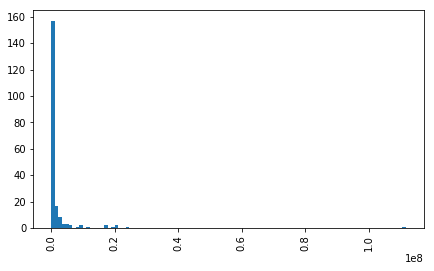

count    2.010000e+02
mean     1.876935e+06
std      8.617823e+06
min      1.000000e+00
25%      1.614000e+03
50%      5.275000e+04
75%      6.559250e+05
max      1.116042e+08
Name: arrivals_in_qtl, dtype: float64

In [6]:
arrivals = data2.groupby('Commodity')['arrivals_in_qtl'].sum()
plt.figure(figsize=(7,4))
plt.hist(arrivals,bins=100)
plt.xticks(rotation='vertical')
plt.show()
arrivals.describe()

In [8]:
print(arrivals[arrivals>=10**8])

Commodity
onion    111604150
Name: arrivals_in_qtl, dtype: int64


From the data it can be seen that there are crops that have been supplied in very less quantities as compared to rest of the crops (about 75%) with most having arrivals in the range of 10<sup>3</sup> to 10<sup>5</sup> quintals, and one crop having more than 10<sup>8</sup> quintals. Hence crops with arrivals less than 10<sup>3</sup> are removed.

In [19]:
data1.to_csv('data1_cleaned.csv',index=False)
data2.to_csv('data2_cleaned.csv',index=False)

## De-seasonalizing prices

Firstly, the two datasets are joined to find commodities that are common and then prices of these in various apmc's are studied and compared with minimum support price.

In [52]:
merged = pd.merge(data2,data1,on=['Commodity','Year'])
merged.date = pd.to_datetime(merged.date)
merged.set_index('date',inplace=True)
print(merged.head())
print(len(merged['Commodity'].unique()))

                  APMC Commodity  Year  Month  arrivals_in_qtl  min_price  \
date                                                                        
2015-04-01  Ahmednagar     bajri  2015  April               79       1406   
2015-04-01       Akole     bajri  2015  April               52       1357   
2015-04-01     Jamkhed     bajri  2015  April              164       1304   
2015-04-01   Kopargaon     bajri  2015  April              354       1164   
2015-04-01      Newasa     bajri  2015  April               32       1282   

            max_price  modal_price district_name   state_name          Type  \
date                                                                          
2015-04-01       1538         1463    Ahmadnagar  Maharashtra  Kharif Crops   
2015-04-01       1800         1525    Ahmadnagar  Maharashtra  Kharif Crops   
2015-04-01       1446         1375    Ahmadnagar  Maharashtra  Kharif Crops   
2015-04-01       1469         1401    Ahmadnagar  Maharashtra  Kh

After removing outliers and merging the datasets, 19 crops are left. Firstly, the prices of each of these crops (in the APMC where maximum quintals have arrived) are deseasonalized and the seasonality type is identified. 

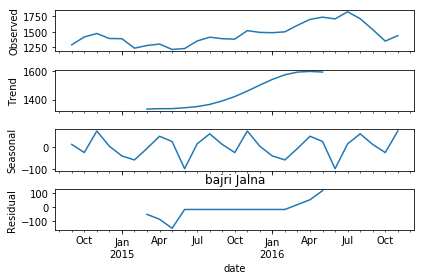

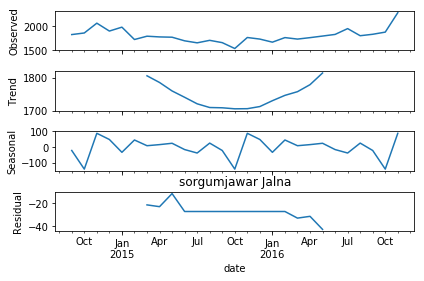

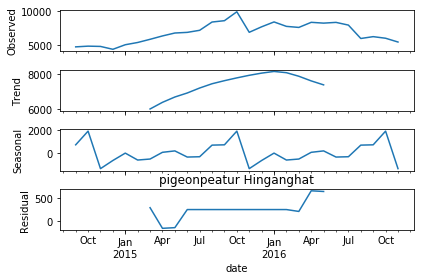

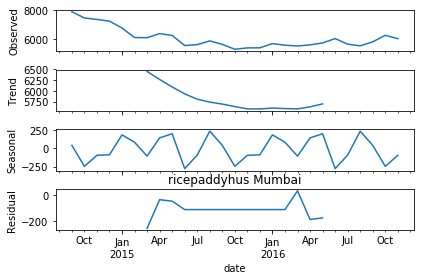

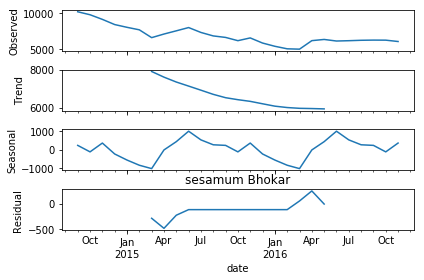

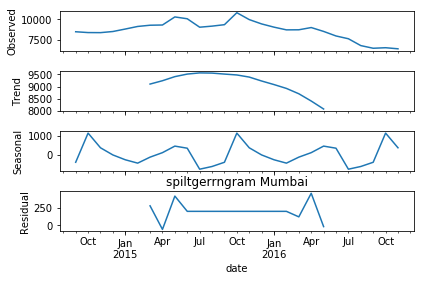

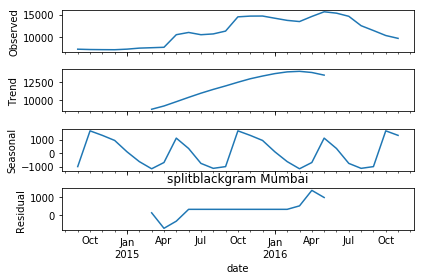

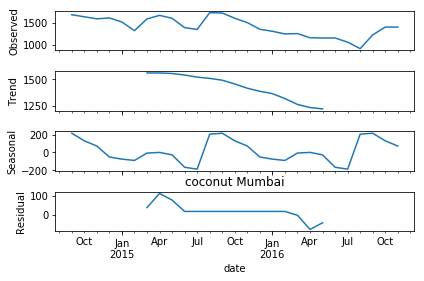

In [54]:
for com in merged['Commodity'].unique():    
    com_data = merged[merged['Commodity']==com]
    maxapmc = com_data.groupby('APMC')['arrivals_in_qtl'].sum().idxmax()
    com_data = com_data.sort_index()
    apmc_com_data = com_data[com_data['APMC']==maxapmc]
    if len(apmc_com_data) < 27:     #This is a check to identify the cases where crop was not recieved for a month
        continue
    decomposed = seasonal_decompose(apmc_com_data['modal_price'],model='Additive',freq=12)
    decomposed.plot()
    plt.title(com+' '+maxapmc)

From the above plots, we can see that there are no patterns present in the residual in any case. Hence the time series is of **additive form**. Now we can plot and compare the minimum support price of the commodity and the trend of its price in each of the APMC's where it is available.
For this, firstly we need to identify the relevant APMC's corresponding to each commodity by observing the number of arrivals in quintals.

In [55]:
for com in merged['Commodity'].unique():
    com_data = merged[merged['Commodity']==com]
    arrivals = com_data.groupby('APMC')['arrivals_in_qtl'].sum()
    print(com)
    print()
    print(arrivals.describe())
    print(arrivals[arrivals>.2*max(arrivals)].describe())
    print()

bajri

count       138.000000
mean      11027.768116
std       20415.119953
min           1.000000
25%         319.500000
50%        2208.500000
75%       12972.250000
max      139224.000000
Name: arrivals_in_qtl, dtype: float64
count        14.000000
mean      59734.000000
std       32067.464708
min       28057.000000
25%       44134.750000
50%       48827.500000
75%       60313.500000
max      139224.000000
Name: arrivals_in_qtl, dtype: float64

wheathusked

count       216.000000
mean      17578.032407
std       39921.804194
min           1.000000
25%         792.750000
50%        3575.500000
75%       14599.500000
max      310586.000000
Name: arrivals_in_qtl, dtype: float64
count        14.000000
mean     150826.642857
std       61646.514169
min       88796.000000
25%      106331.750000
50%      133479.000000
75%      157843.500000
max      310586.000000
Name: arrivals_in_qtl, dtype: float64

sorgumjawar

count       219.000000
mean      24826.470320
std       60208.173846
min     

From the above, we can see that when values above 20% of maximum value are considered then most of them are of the same order as the max value. Hence being relevant, these APMC's will be selected. Now we can plot the MSP and trend of each commodity corresponding to the selected APMC.

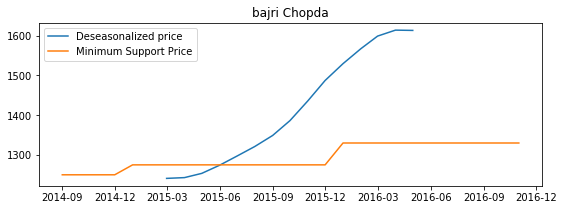

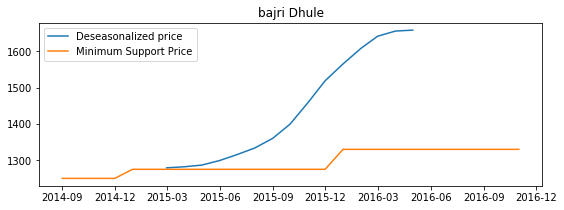

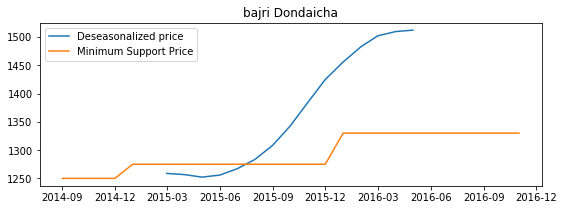

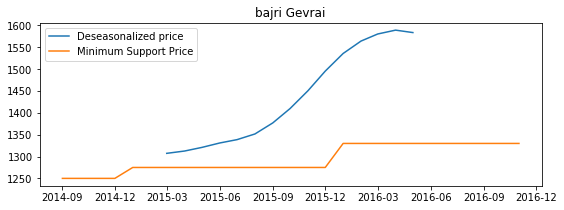

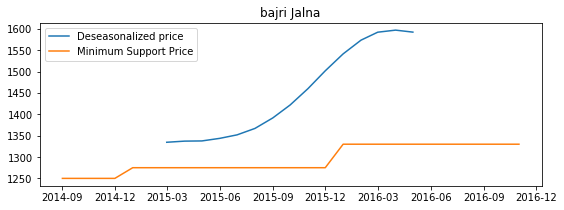

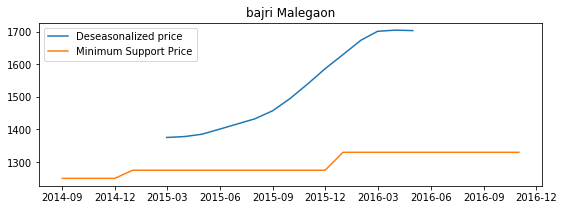

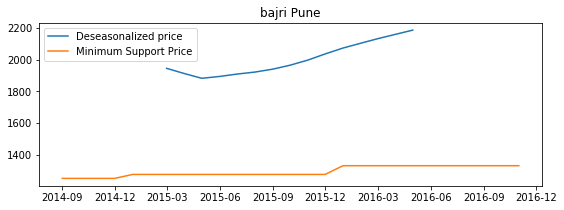

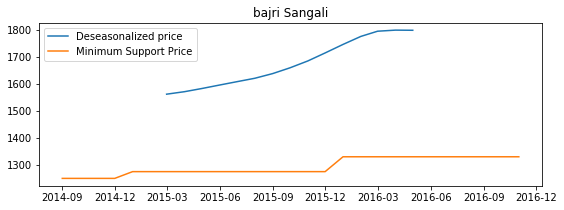

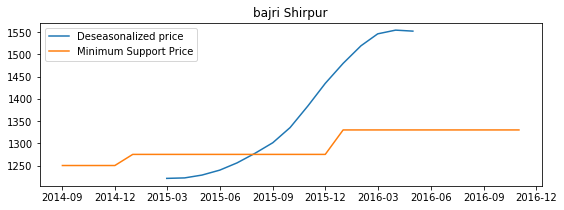

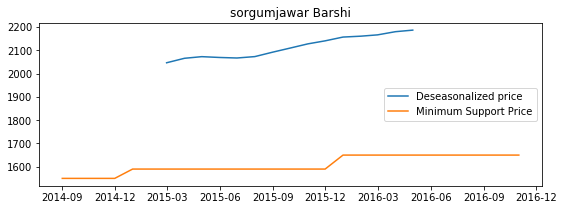

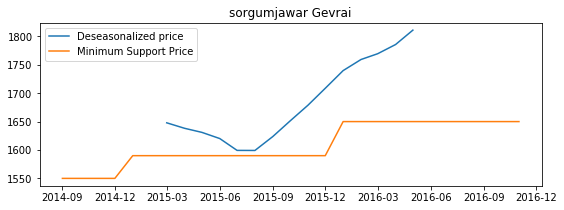

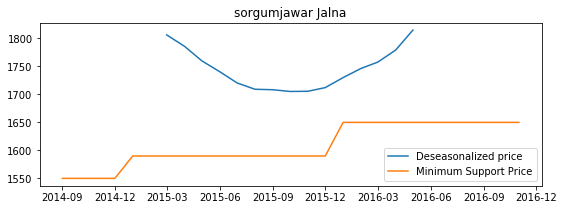

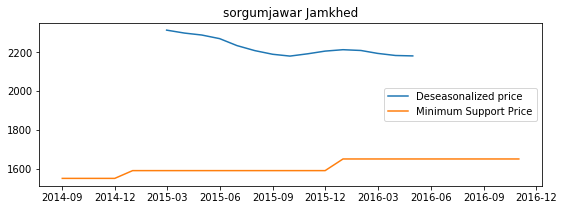

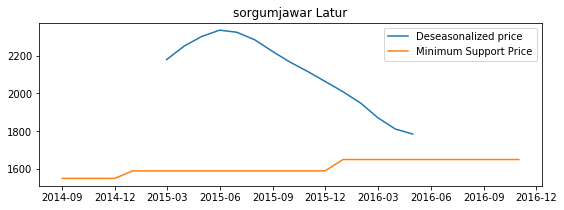

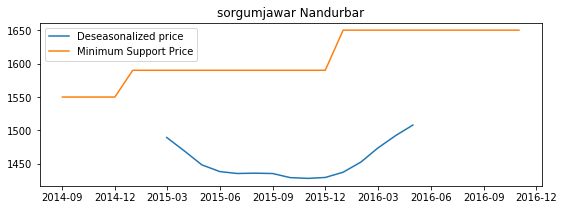

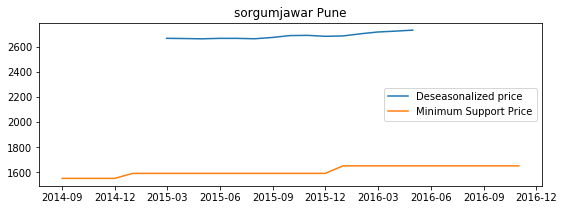

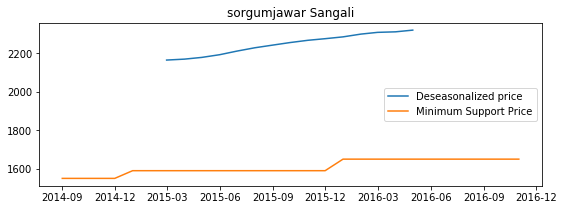

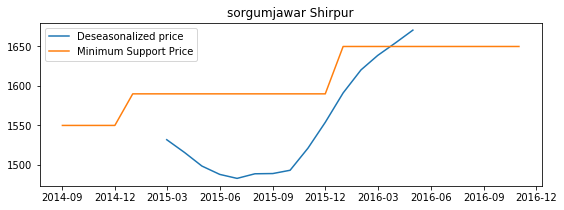

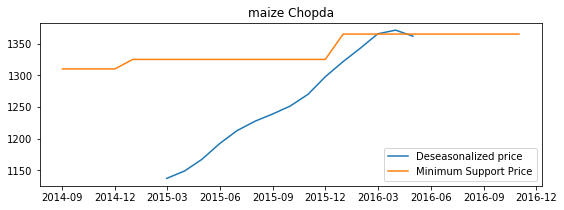

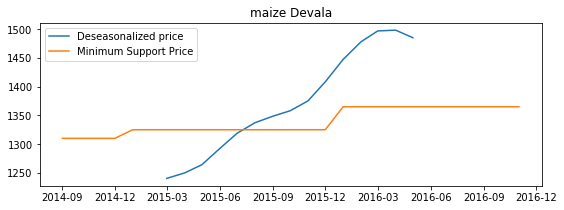

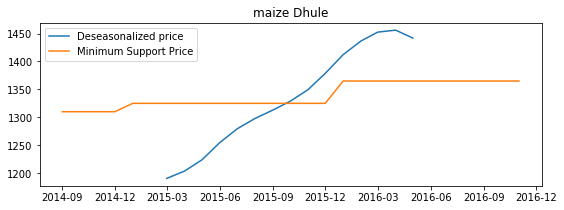

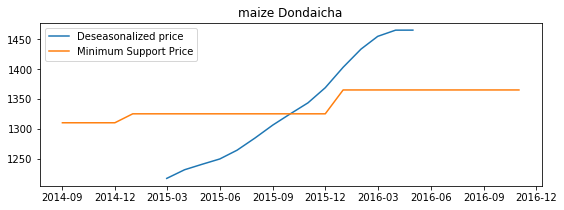

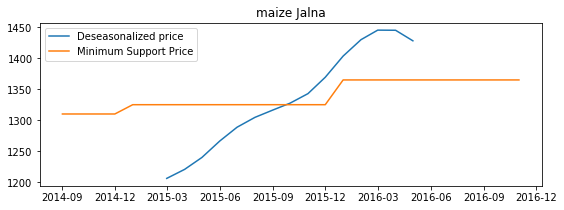

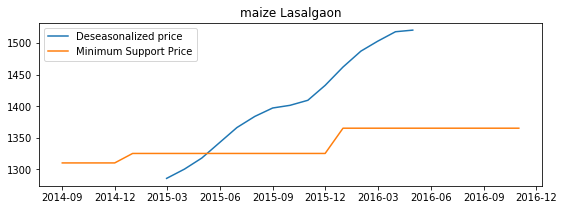

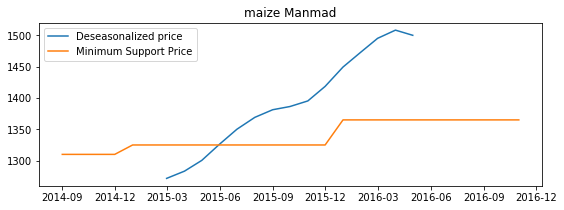

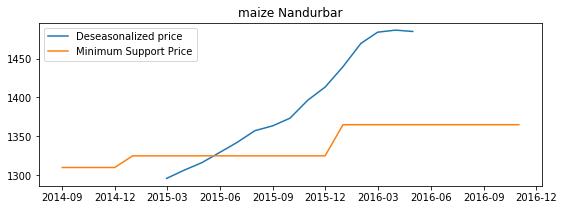

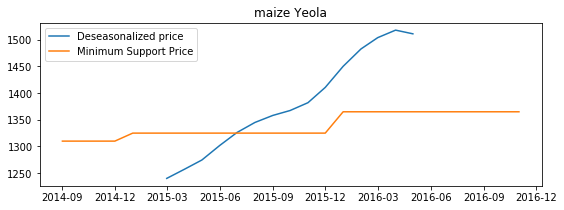

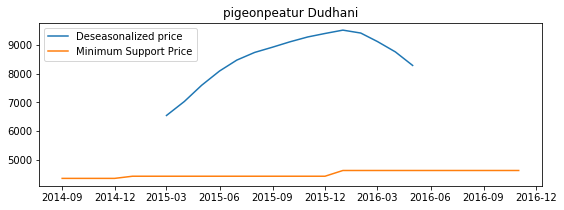

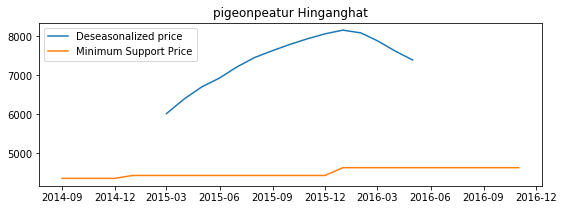

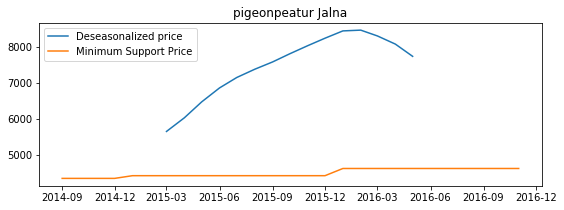

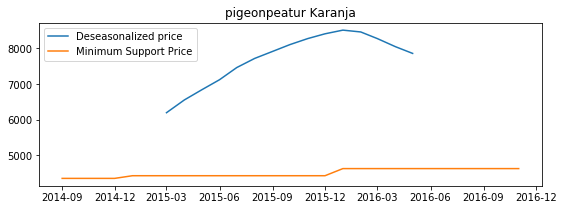

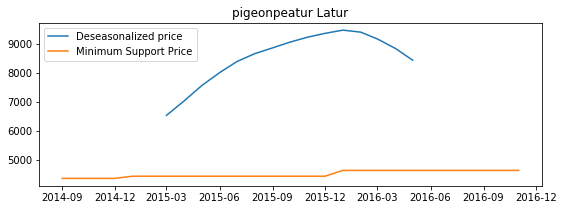

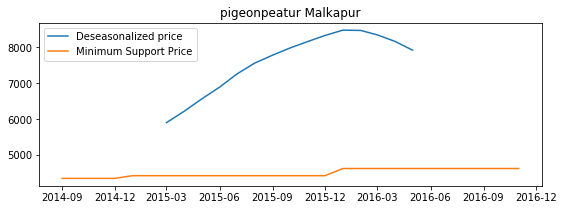

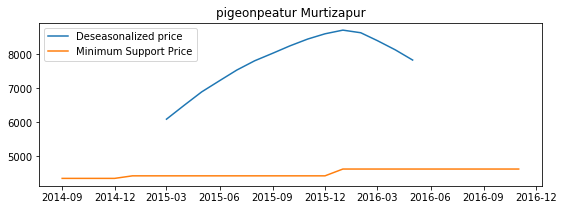

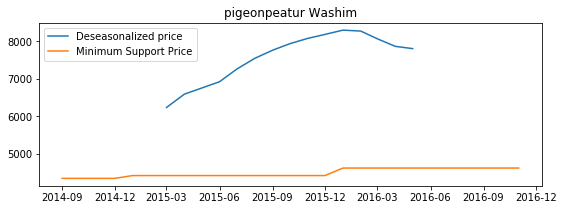

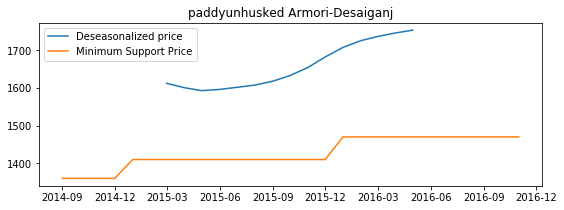

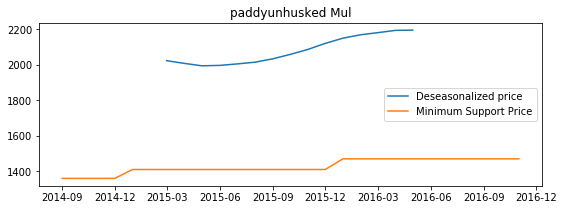

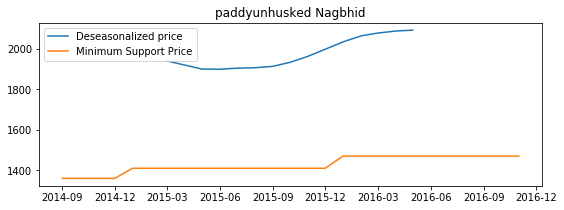

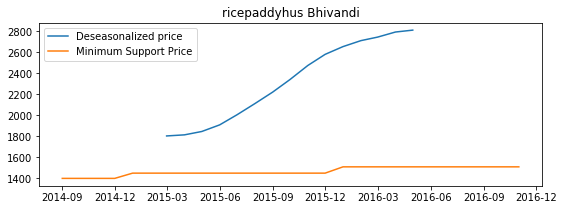

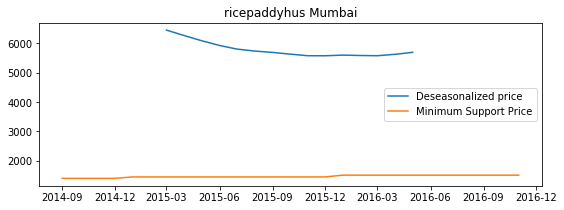

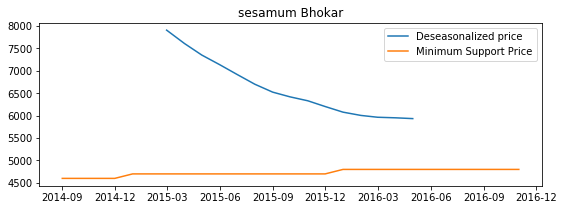

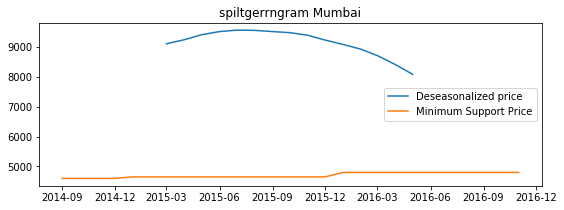

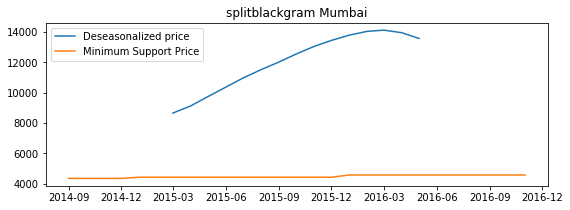

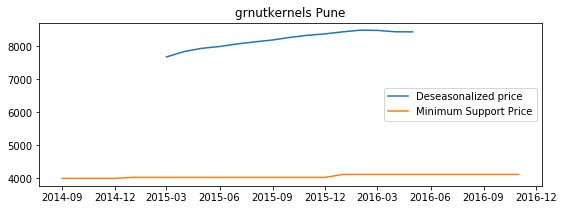

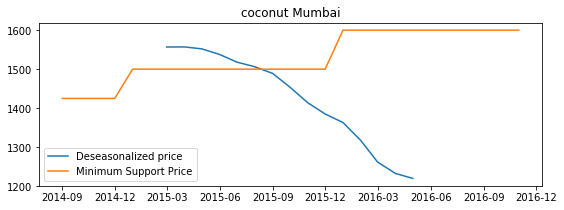

In [65]:
for com in merged['Commodity'].unique():
    com_data = merged[merged['Commodity']==com]
    com_data = com_data.sort_index()
    arrivals = com_data.groupby('APMC')['arrivals_in_qtl'].sum()
    apmcs = arrivals[arrivals>.2*max(arrivals)].keys()
    for apmc in apmcs:
        apmc_com_data = com_data[com_data['APMC']==apmc]
        if len(apmc_com_data) < 27:
            continue
        decomposed = seasonal_decompose(apmc_com_data['modal_price'],model='Additive',freq=12)
        deseasonalized = decomposed.trend
        plt.figure(figsize=(9,3))
        plt.plot(deseasonalized,label='Deseasonalized price')
        plt.plot(apmc_com_data['msprice'],label='Minimum Support Price')
        plt.title(com+' '+apmc)
        plt.legend()
        plt.show()

From the above plots, we can see that -  
+ For a particular commodity we see a common trend in price across each APMC.  
+ Prices for most crops have been increasing, except -   
    - Sorgumjawar - price has varying trend across different APMC's 
    - Coconut,Sesamum - price has decreased  
    - Pigeonpeatur - price increased initially and then decreased  
+ At some APMC's, the commodity price violates the minimum support price, namely-  
    - Nandurbar (Sorgumjawar)  
    - Mumbai (Coconut)  
    - Chopda (Maize)

## APMC's with highest standard deviation in modal price of commodities

To analyze the APMC that show high variation in prices across commodities, a bar graph showing standard deviation of the price of commodity in different APMC's is plotted. APMC's that are showing highest variation in the **deseasonalized** prices (with a significant difference in variation of other APMC's of the same commodity) for most crops are found.

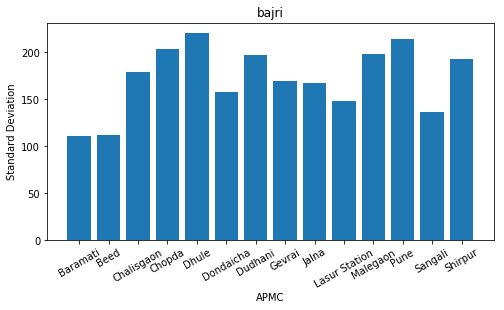

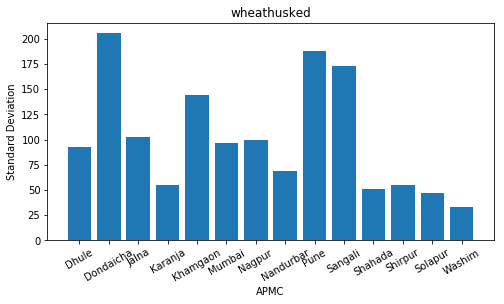

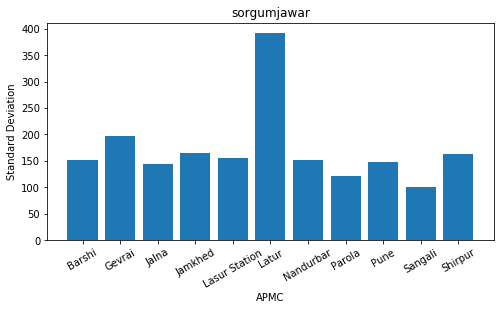

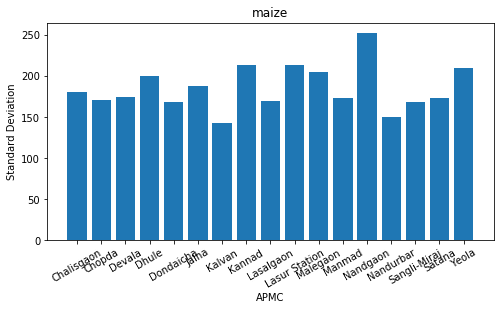

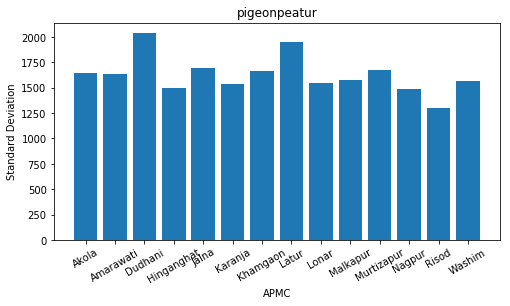

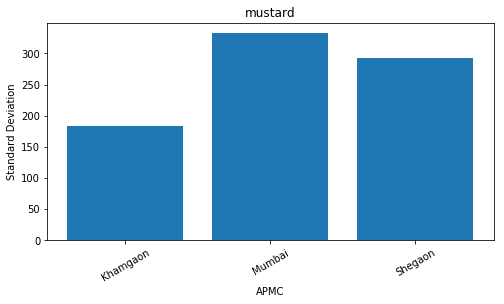

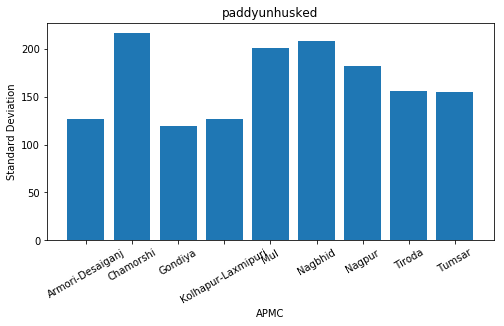

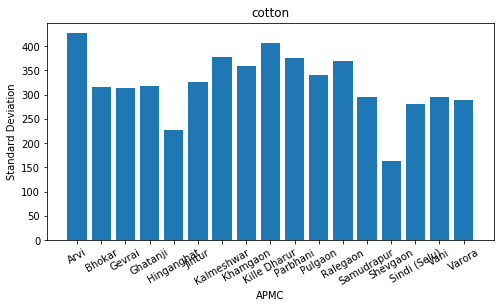

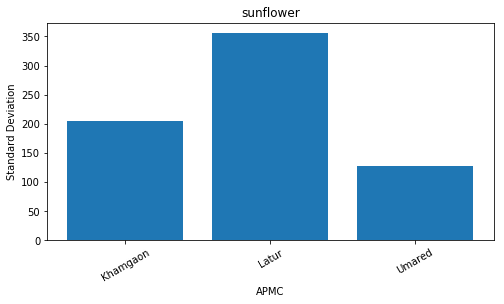

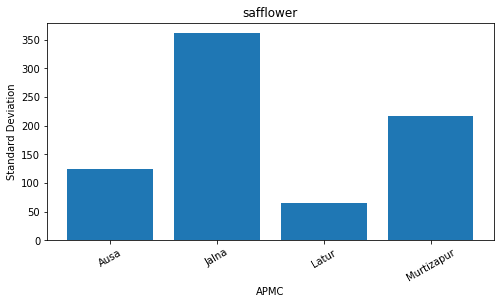

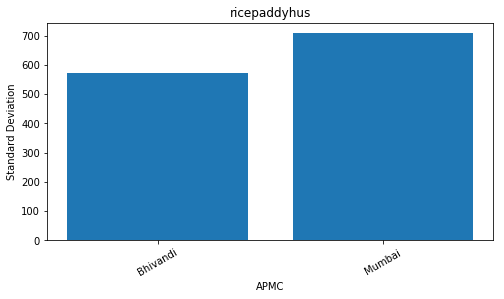

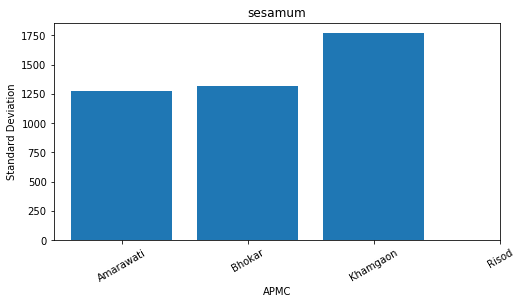

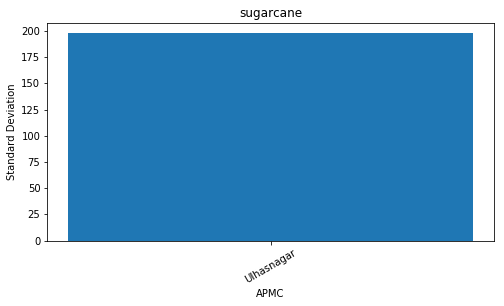

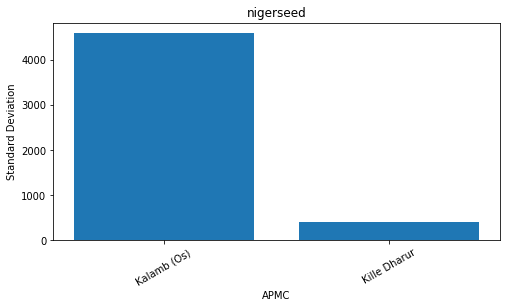

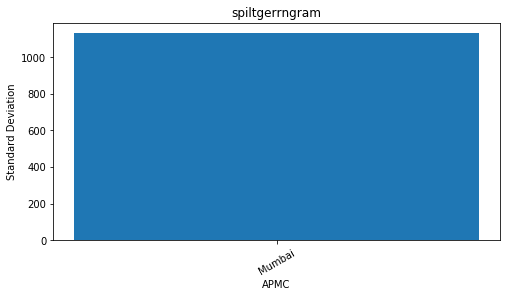

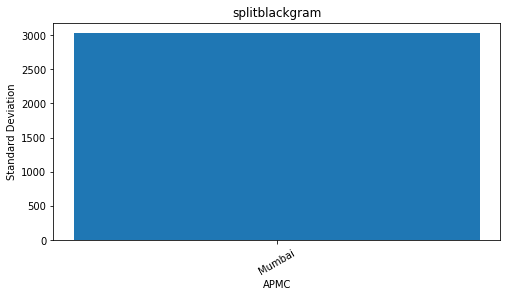

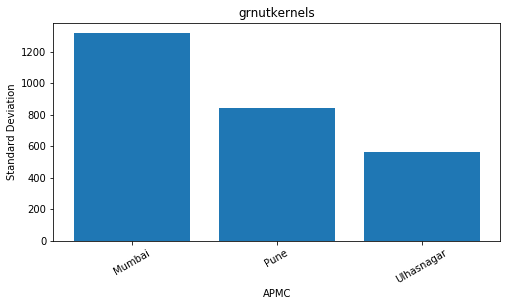

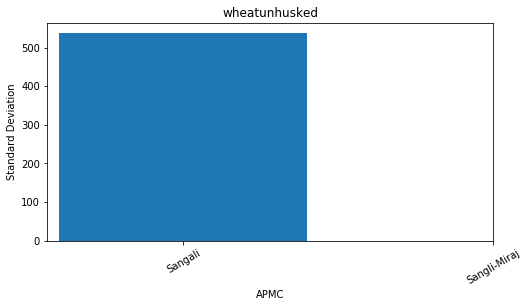

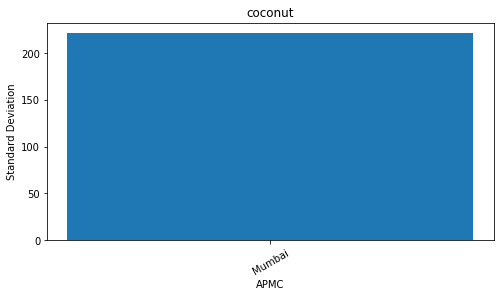

In [101]:
for com in merged['Commodity'].unique():
    com_data = merged[merged['Commodity']==com]
    com_data = com_data.sort_index()
    arrivals = com_data.groupby('APMC')['arrivals_in_qtl'].sum()
    apmcs = arrivals[arrivals>.2*max(arrivals)].keys()
    devs=[]
    for apmc in apmcs:
        apmc_com_data = com_data[com_data['APMC']==apmc]
        dev = apmc_com_data['modal_price'].std()
        devs.append(dev)
    devs=np.array(devs)
    index=np.arange(len(apmcs))
    plt.figure(figsize=(8,4))
    plt.bar(index,devs)
    plt.xlabel('APMC')
    plt.ylabel('Standard Deviation')
    plt.xticks(index, apmcs, rotation=30)
    plt.title(com)
    plt.show()
    
        

From the above, it can be concluded that -  
1) Mumbai has highest variation in prices in most cases.  
2) Latur has a very high variation in price of sorgumjawar  
3) Jalna has high variation in price of Safflower  
4) Kalamb has high variation in price of Nigerseed